<a href="https://colab.research.google.com/github/BroccoliWarrior/transformer-basic-knowledge/blob/main/FFN%26Activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***FFN***

purpose：通过非线性激活函数和线性变换，逐步学习并将输入特征映射到更高维度的特征空间，以此增强模型的表达能力



**最基础的FFN与激活函数**

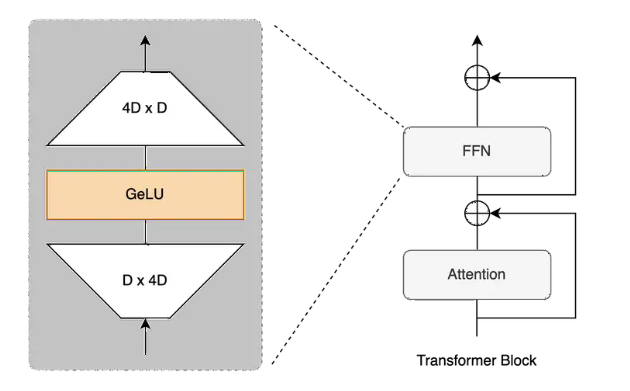

1.第一层全连接（线性变换）

  $z=xW_1+b_1$

其中，$W_1$是权重矩阵，$b_1$是偏执向量，输入$x$的维度通常是比$d_{model}$大很多（一般是4倍）

2.激活函数

  $a=F(z)$

原论文是ReLU，也可以替换其它的

3.第二层全连接层（线性变换）

  $y=aW_2+b_2$

其中，$W_2$的维度与$z$的相同，输出回到与$x$相同的维度$d_{model}$，为了方便后续的操作

综合公式：

  $FFN(x)=F(xW_1+b_1)W_2+b_2$

## **常见的激活函数**

***1.ReLU***

  $ReLU(x)=max(0,x)$

    * 计算简单，速度快，不容易发生梯度弥散
    * 当输入小于0时，输出恒为0，可能导致某些神经元在训练的过程中一直输出0（神经死亡）
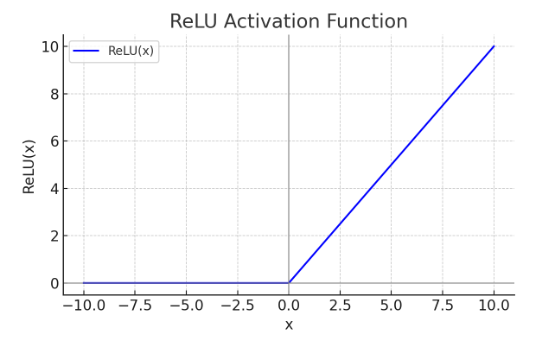

***2.Tanh***

  $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

    * 输出范围在（-1，1），比sigmoid更不容易饱和
    * 依然有饱和的可能，使得梯度变小减缓训练的进度

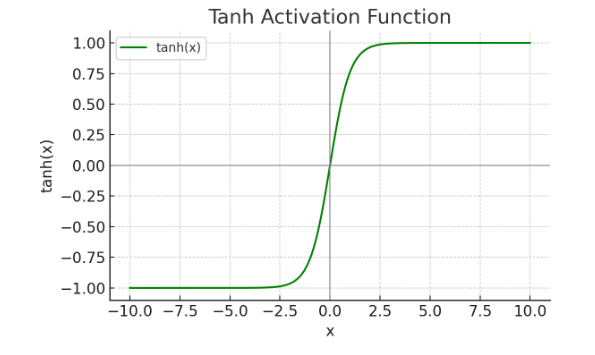

***3.Sigmoid***

  $\sigma(x) = \frac{1}{1 + e^{-x}}$

    * 输出范围在（0，1），可以当作开关
    * 容易出现梯度饱和，计算成本较高

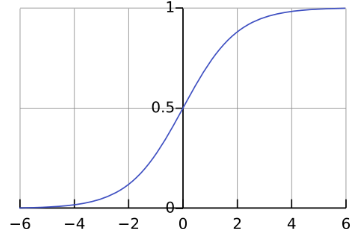

***4.GeLU***

  $\text{GeLU}(x) = x \cdot \Phi(x)$

近似形式如下：

  $\text{GeLU}(x) \approx \frac{1}{2}x\left(1 + \tanh\left[\sqrt{\frac{2}{\pi}}\left(x + 0.044715x^{3}\right)\right]\right)$

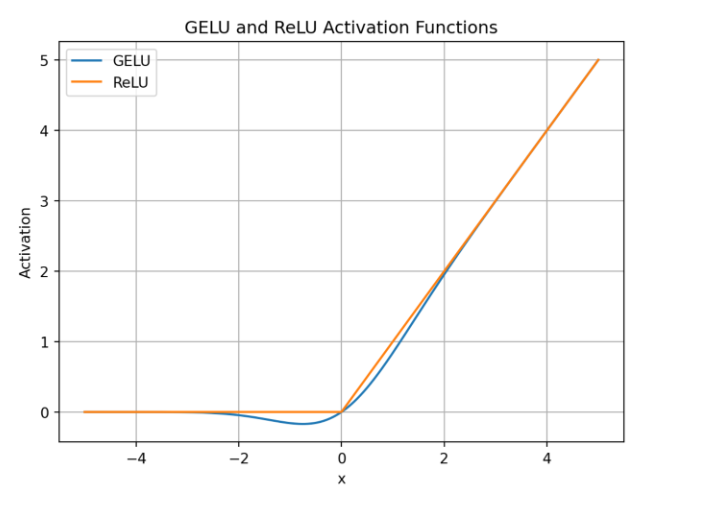

In [ ]:
import numpy as np

def GeLU(x):
  return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) + 0.044715 * x**3))

*GeLu与ReLU的差别*

    * GeLU是平滑的曲线，梯度连续，而ReLU在x=0处存在拐点，梯度不连续
    * ReLU对所有的负值输出都是0，而GeLU则会有一定的概率保留负值，一定程度上避免“神经死亡”的问题
    * ReLU是简单的分段函数，相比于GeLU计算成本更低
    * ReLU时候用在卷据神经网络（CNN）中，GeLU适合全连接网络（FNN）

***5.Swish***

  $Swish(x)=x\cdotσ(βx)$

其中的$σ(⋅)$是Sigmoid函数


    * $β=1$，曲线与GeLU相近；

    * $β=0$，线性函数x；

    * $β\to∞$，曲线趋近于ReLU


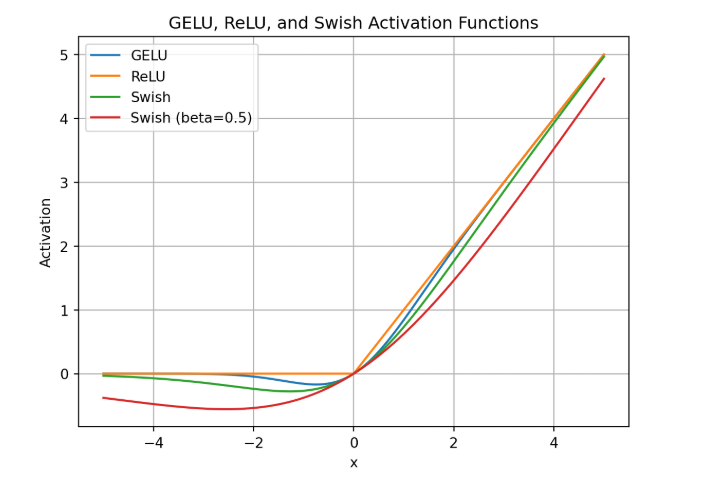

# ***基于GLU（Gated Linear Unit）的FFN***

GLU是一种门控机制，将全连接输出分为两个部分：

    * 主干输出
    * 经过门控函数（Sigmoid或其它）来选择性的“保留”或“抑制”信息

$GLU(x)=F(xW+b)⊙(xV+c)$

    * $⊙$是矩阵element-wise乘积，就是逐（对应）元素相乘，结果张量维度不变
    * $F(⋅)$是任意激活函数

根据选择的激活函数的不同，可以分为**GeGLU**和**SwiGLU**


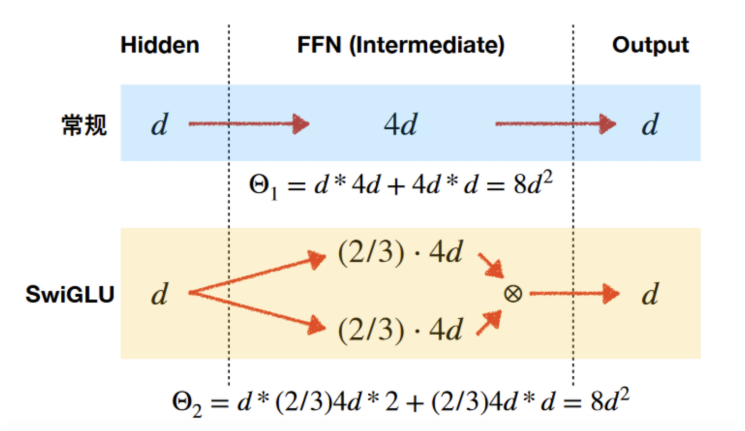

为了尽量保持参数量不变，immediate_dim变为之前的2/3

In [4]:
import torch
import torch.nn.functional as F  # 导入PyTorch的函数式接口，用于激活函数等操作
from torch import nn  # 导入PyTorch的神经网络模块

class FeedForward(nn.Module):
    """
    基于SwiGLU激活函数的前馈神经网络，用于Transformer架构中
    SwiGLU是GLU（Gated Linear Unit）的变体，结合了SiLU激活函数的门控机制
    """
    def __init__(self, dim:int, hidden_dim:int, multiple_of:int, dropout:float) -> None:
        super().__init__()
        # 调整隐藏层维度：
        # 1. 先将hidden_dim缩放至约2/3（SwiGLU的标准设计）
        # 2. 再确保结果是multiple_of的整数倍（硬件加速需求）
        # 公式解析：
        # (2 * hidden_dim // 3) → 缩放至约2/3
        # (x + multiple_of - 1) // multiple_of → 向上取整到最近的multiple_of倍数
        hidden_dim = multiple_of * ((2 * hidden_dim // 3 + multiple_of - 1) // multiple_of)

        # 定义三个线性变换层
        self.w1 = nn.Linear(dim, hidden_dim)  # 第一个线性层：输入→隐藏层
        self.w2 = nn.Linear(hidden_dim, dim)  # 第二个线性层：隐藏层→输出（恢复原维度）
        self.w3 = nn.Linear(dim, hidden_dim)  # 第三个线性层：输入→隐藏层（门控分支）
        self.dropout = nn.Dropout(dropout)    # Dropout层：防止过拟合

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        前向传播过程，实现SwiGLU激活函数
        公式：SwiGLU(x) = w2( SiLU(w1(x)) ⊙ w3(x) )
            其中：
            - SiLU(x) = x · σ(x) （Sigmoid加权线性单元）
            - ⊙ 表示逐元素乘法（Hadamard乘积）
        """
        # 步骤1：计算SiLU(w1(x)) → 门控信号
        # w1(x)将输入x从dim维度映射到hidden_dim
        # F.silu实现SiLU激活函数：SiLU(a) = a * σ(a)
        silu_output = F.silu(self.w1(x))  # 形状: [batch_size, seq_len, hidden_dim]

        # 步骤2：计算w3(x) → 被门控的信号
        # w3(x)同样将输入x从dim维度映射到hidden_dim
        w3_output = self.w3(x)  # 形状: [batch_size, seq_len, hidden_dim]

        # 步骤3：门控操作（逐元素乘法）
        gated_output = silu_output * w3_output  # 形状: [batch_size, seq_len, hidden_dim]

        # 步骤4：通过w2将维度从hidden_dim恢复到dim，并应用dropout
        return self.dropout(self.w2(gated_output))  # 形状: [batch_size, seq_len, dim]
